# <h1><center>ST308 Assessed Coursework</center></h1>

In [1]:
import pystan
import arviz as az # Visualisations library for Bayesian analysis
import numpy as np
import pickle
from scipy import optimize, stats
from scipy.special import expit
import scipy as sc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, balanced_accuracy_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from uszipcode import SearchEngine # Library to convert 'Zip Code' variable to 'County'

sns.set()
import matplotlib.gridspec as gridspec
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
import warnings
warnings.filterwarnings('ignore')

The dataset can be found here:
[Personal Loan Dataset](https://www.kaggle.com/itsmesunil/bank-loan-modelling?fbclid=IwAR2ucPpVLXQrzDQmIwe7-G0zLfujeBTvRUzrXm1W2pJ0tGb7TTH3ozgYq58)

In [2]:
data = pd.read_excel('data.xlsx' , sheet_name = 'Data' , index_col = 'ID')

In [3]:
data.head() # For categotical: '1' denotes Yes and '0' denotes No

Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
ID                                                                          
1    25           1      49     91107       4    1.6          1         0   
2    45          19      34     90089       3    1.5          1         0   
3    39          15      11     94720       1    1.0          1         0   
4    35           9     100     94112       1    2.7          2         0   
5    35           8      45     91330       4    1.0          2         0   

    Personal Loan  Securities Account  CD Account  Online  CreditCard  
ID                                                                     
1               0                   1           0       0           0  
2               0                   1           0       0           0  
3               0                   0           0       0           0  
4               0                   0           0       0           0  
5               0                   0           0       0           1

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 1 to 5000
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   ZIP Code            5000 non-null   int64  
 4   Family              5000 non-null   int64  
 5   CCAvg               5000 non-null   float64
 6   Education           5000 non-null   int64  
 7   Mortgage            5000 non-null   int64  
 8   Personal Loan       5000 non-null   int64  
 9   Securities Account  5000 non-null   int64  
 10  CD Account          5000 non-null   int64  
 11  Online              5000 non-null   int64  
 12  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(12)
memory usage: 546.9 KB


<AxesSubplot:>

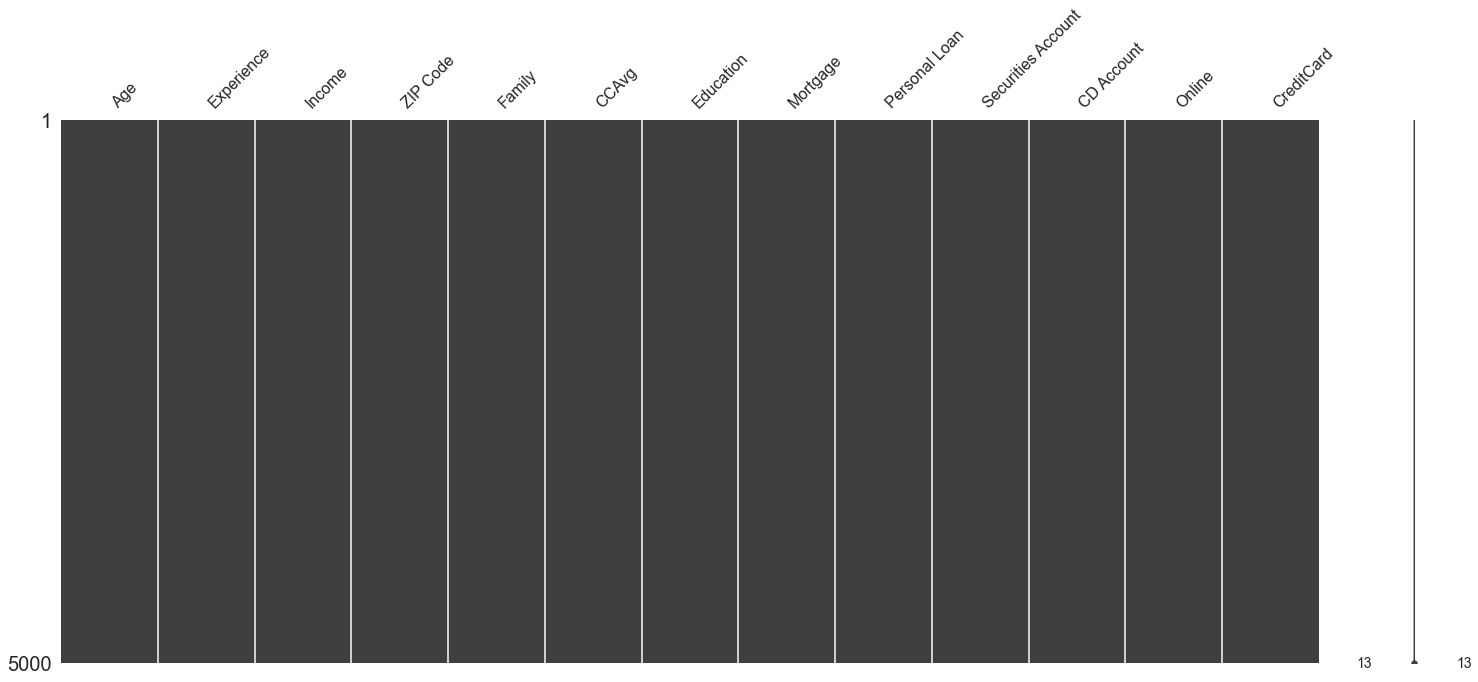

In [5]:
msno.matrix(data) # No missing values

In [6]:
data.describe().round(1)

Age  Experience  Income  ZIP Code  Family   CCAvg  Education  \
count  5000.0      5000.0  5000.0    5000.0  5000.0  5000.0     5000.0   
mean     45.3        20.1    73.8   93152.5     2.4     1.9        1.9   
std      11.5        11.5    46.0    2121.9     1.1     1.7        0.8   
min      23.0        -3.0     8.0    9307.0     1.0     0.0        1.0   
25%      35.0        10.0    39.0   91911.0     1.0     0.7        1.0   
50%      45.0        20.0    64.0   93437.0     2.0     1.5        2.0   
75%      55.0        30.0    98.0   94608.0     3.0     2.5        3.0   
max      67.0        43.0   224.0   96651.0     4.0    10.0        3.0   

       Mortgage  Personal Loan  Securities Account  CD Account  Online  \
count    5000.0         5000.0              5000.0      5000.0  5000.0   
mean       56.5            0.1                 0.1         0.1     0.6   
std       101.7            0.3                 0.3         0.2     0.5   
min         0.0            0.0                 0.0         0.0     0.0   
25%         0.0            0.0                 0.0         0.0     0.0   
50%         0.0            0.0                 0.0         0.0     1.0   
75%       101.0            0.0                 0.0         0.0     1.0   
max       635.0            1.0                 1.0         1.0     1.0   

       CreditCard  
count      5000.0  
mean          0.3  
std           0.5  
min           0.0  
25%           0.0  
50%           0.0  
75%           1.0  
max           1.0

Notice that the 'Experience' variable has -3 as its minimum value so something is clearly wrong. We therefore further investigate this variable.

In [7]:
data[data['Experience'] < 0].head(15)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
ID                                                                           
90    25          -1     113     94303       4   2.30          3         0   
227   24          -1      39     94085       2   1.70          2         0   
316   24          -2      51     90630       3   0.30          3         0   
452   28          -2      48     94132       2   1.75          3        89   
525   24          -1      75     93014       4   0.20          1         0   
537   25          -1      43     92173       3   2.40          2       176   
541   25          -1     109     94010       4   2.30          3       314   
577   25          -1      48     92870       3   0.30          3         0   
584   24          -1      38     95045       2   1.70          2         0   
598   24          -2     125     92835       2   7.20          1         0   
650   25          -1      82     92677       4   2.10          3         0   
671   23          -1      61     92374       4   2.60          1       239   
687   24          -1      38     92612       4   0.60          2         0   
794   24          -2     150     94720       2   2.00          1         0   
890   24          -2      82     91103       2   1.60          3         0   

     Personal Loan  Securities Account  CD Account  Online  CreditCard  
ID                                                                      
90               0                   0           0       0           1  
227              0                   0           0       0           0  
316              0                   0           0       1           0  
452              0                   0           0       1           0  
525              0                   0           0       1           0  
537              0                   0           0       1           0  
541              0                   0           0       1           0  
577              0                   0           0       0           1  
584              0                   0           0       1           0  
598              0                   1           0       0           1  
650              0                   0           0       1           0  
671              0                   0           0       1           0  
687              0                   0           0       1           0  
794              0                   0           0       1           0  
890              0                   0           0       1           1

Judging from the age of the inviduals, we can conclude that this is some sort of typo and we proceed by converting those negative numbers to positive.

In [8]:
data['Experience'] = data['Experience'].apply(np.abs)

We now group ZIP Codes according to the County to which they belong, to create a more meaningful variable which will be also useful for Hierarchical models.

In [9]:
search = SearchEngine()

def extract_county(row):
    zipcode = int(row['ZIP Code'])
    county = search.by_zipcode(zipcode).county
    
    if county is None:
        return 'NA'
    
    county_name = county.split(' ')[:-1]
    county_final = ' '.join(county_name) # extract the name of county only
    return county_final

In [10]:
data['County'] = data.apply(lambda row: extract_county(row) , axis=1 )
data.drop('ZIP Code' , axis=1 , inplace=True) # This column no longer needed

In [11]:
data['County'].unique()

array(['Los Angeles', 'Alameda', 'San Francisco', 'San Diego', 'Monterey',
       'Ventura', 'Santa Barbara', 'Marin', 'Santa Clara', 'Santa Cruz',
       'San Mateo', 'Humboldt', 'Contra Costa', 'Orange', 'Sacramento',
       'Yolo', 'Placer', 'San Bernardino', 'San Luis Obispo', 'Riverside',
       'Kern', 'NA', 'Fresno', 'Sonoma', 'El Dorado', 'San Benito',
       'Butte', 'Solano', 'Mendocino', 'San Joaquin', 'Imperial',
       'Siskiyou', 'Merced', 'Trinity', 'Stanislaus', 'Shasta',
       'Tuolumne', 'Napa', 'Lake'], dtype=object)

In [12]:
data.head()

Age  Experience  Income  Family  CCAvg  Education  Mortgage  \
ID                                                                
1    25           1      49       4    1.6          1         0   
2    45          19      34       3    1.5          1         0   
3    39          15      11       1    1.0          1         0   
4    35           9     100       1    2.7          2         0   
5    35           8      45       4    1.0          2         0   

    Personal Loan  Securities Account  CD Account  Online  CreditCard  \
ID                                                                      
1               0                   1           0       0           0   
2               0                   1           0       0           0   
3               0                   0           0       0           0   
4               0                   0           0       0           0   
5               0                   0           0       0           1   

           County  
ID                 
1     Los Angeles  
2     Los Angeles  
3         Alameda  
4   San Francisco  
5     Los Angeles

In [13]:
def plots(data, feature):
    
    fig = plt.figure(constrained_layout = True, figsize=(10,8))
    gs = gridspec.GridSpec(nrows=1, ncols=4, figure=fig)

    ax1 = fig.add_subplot(gs[0,:3])    
    sns.distplot(data.loc[data["Personal Loan"]==0,feature],
                 kde = False, color = "#004a4d", norm_hist=False,
                 hist_kws = dict(alpha=0.8), bins=40,
                 label="Non-Loan Customer", ax=ax1);
    
    sns.distplot(data.loc[data["Personal Loan"]==1,feature],
                 kde = False, color = "#7d0101", norm_hist=False,
                 hist_kws = dict(alpha=0.6), bins=40,
                 label="Loan Customer", ax=ax1);
    
    ax2 = fig.add_subplot(gs[0,3])    
    
    if feature in ['Age' , 'Experience','Income','CCAvg','Mortgage']: # Plot boxplot for continuous features
        sns.boxplot(y = data[feature], color = "#989100",
                width = 0.2, ax=ax2);
    
    ax1.legend(loc="upper right");

In [14]:
vars_list = [var for var in data.columns if var not in ('Personal Loan', 'County')]
numeric_vars = ['Age' , 'Experience', 'Income', 'CCAvg', 'Mortgage']
categorical_vars = ['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard']

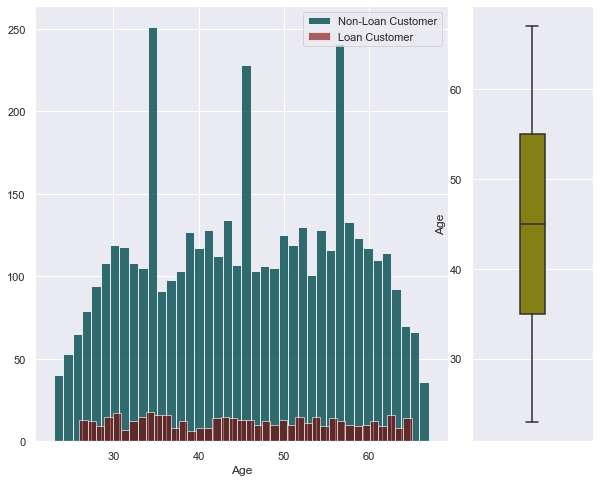

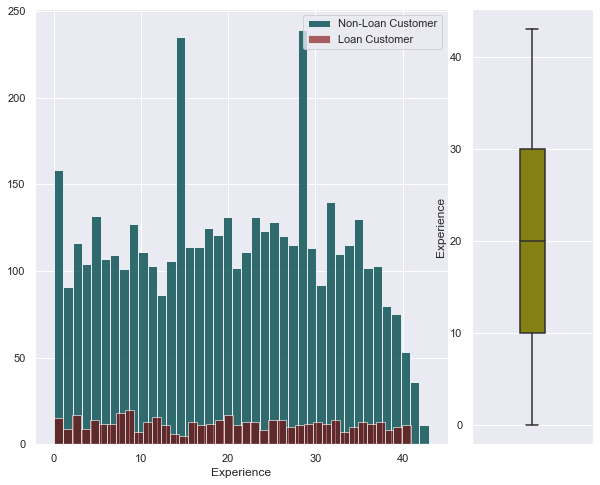

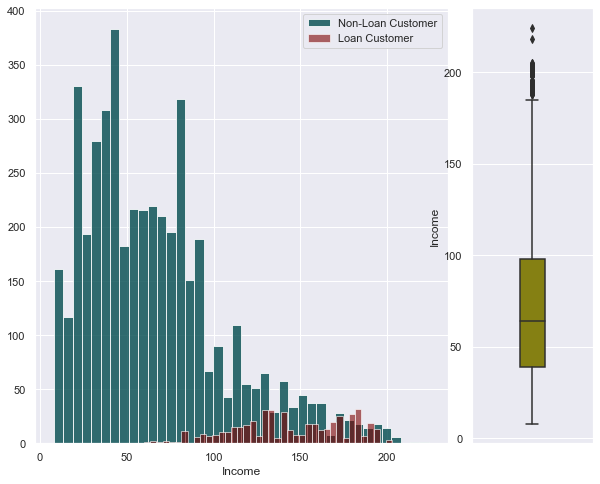

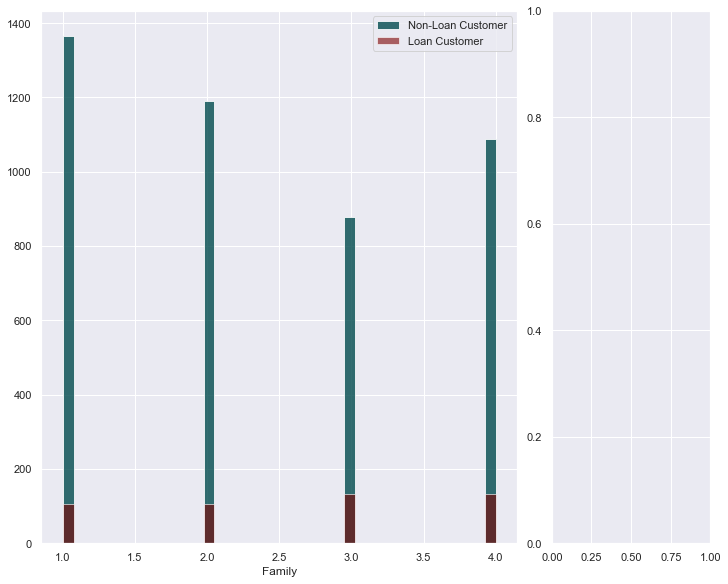

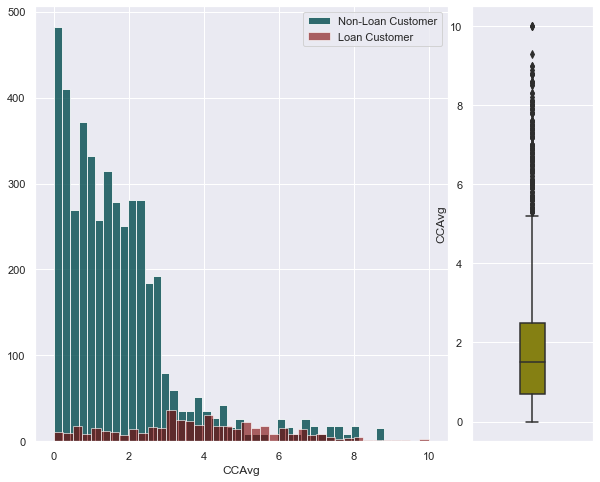

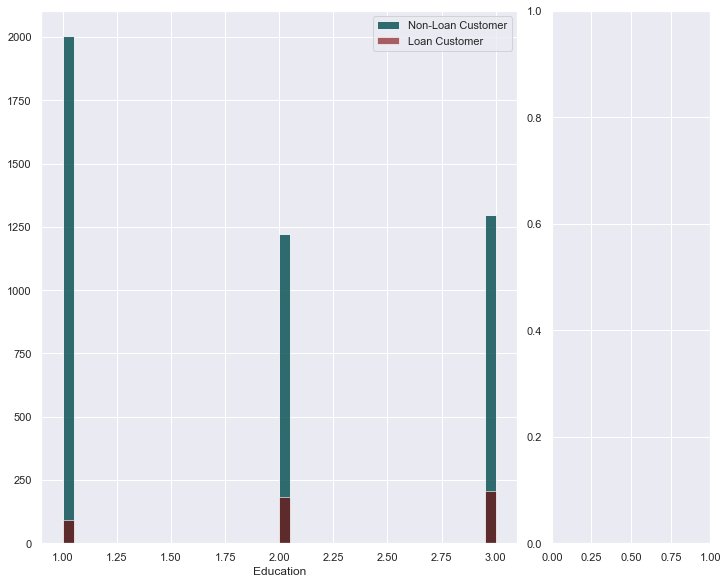

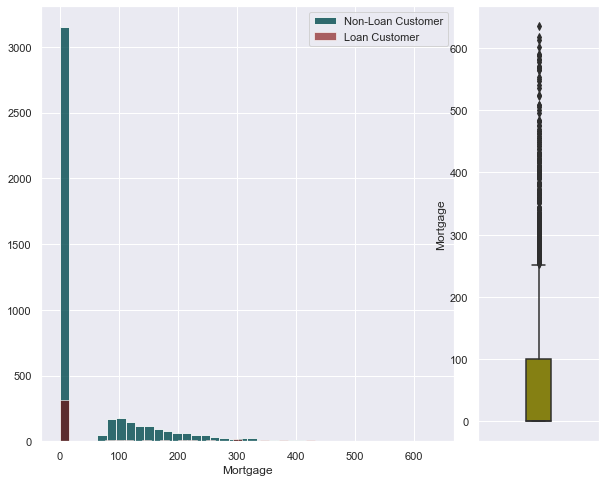

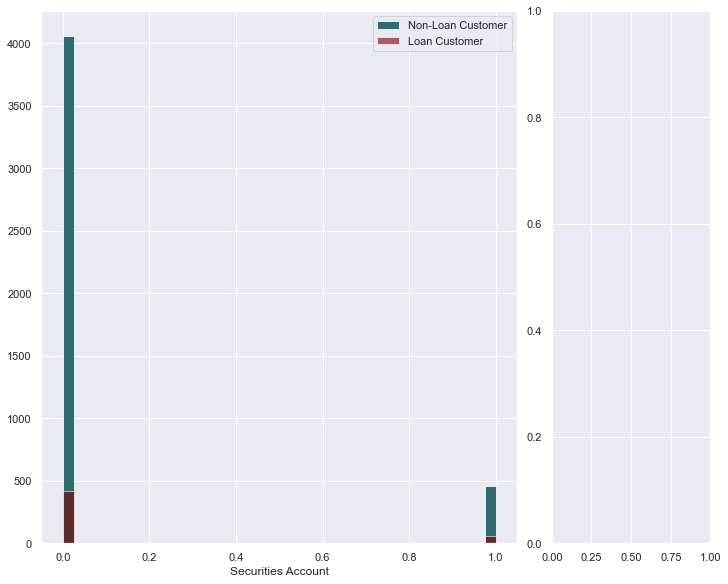

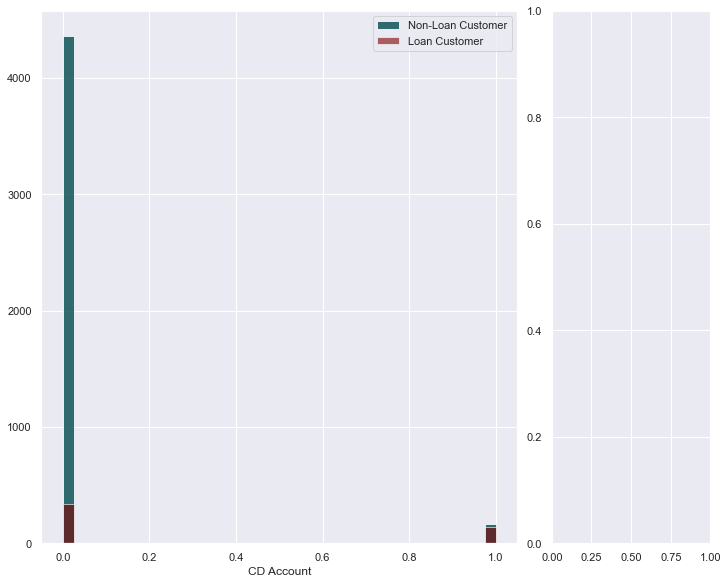

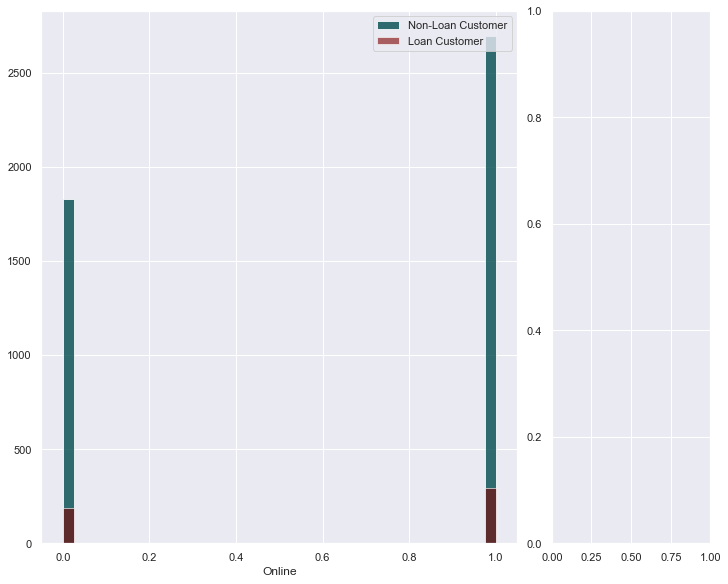

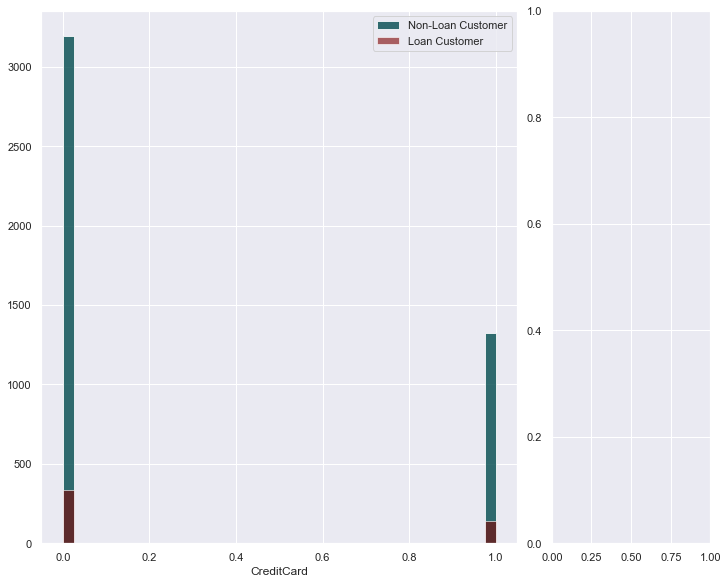

In [15]:
for var in vars_list:
    plots(data, var)

We drop rows with very extreme values for CCAvg and Mortgage to improve the fit of our models.
Note also that outlier removal results to a loss of less than 1% of the dataset so it's sensible to remove them.

In [16]:
data.shape

(5000, 13)

In [17]:
# Drop rows with very extreme values for Mortgage; using a z-score criterion
data['Mortgage_zscores'] = np.abs(stats.zscore(data['Mortgage']))
data['CCAvg_zscores'] = np.abs(stats.zscore(data['CCAvg']))

data = data[data['Mortgage_zscores'] < 4]
data = data[data['CCAvg_zscores'] < 4]

data.drop(['Mortgage_zscores','CCAvg_zscores'] , axis=1, inplace = True)

In [18]:
data.shape

(4958, 13)

Let's have a look at the County variable in more detail

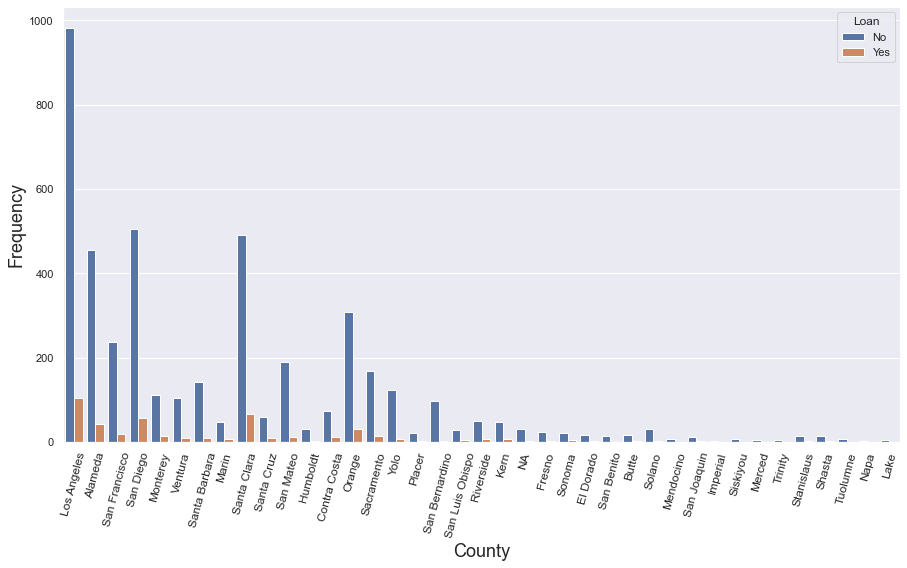

In [19]:
fig = plt.figure( figsize = (15,8) )
sns.countplot(x = 'County' , data = data, hue = 'Personal Loan')
plt.xlabel('County' , fontsize = 18);
plt.xticks(rotation = 75 , fontsize = 12);
plt.ylabel('Frequency' , fontsize = 18);
plt.legend(title='Loan', loc='upper right', labels=['No', 'Yes']);

Let's group together Counties with very few observations into a single group named 'Other', to reduce the large number of distinct Counties and make analysis and interpretation easier.

In [20]:
# Proportion of observations in each County
data['County'].value_counts(normalize = True) * 100

Los Angeles        21.924163
San Diego          11.355385
Santa Clara        11.234369
Alameda            10.024203
Orange              6.837434
San Francisco       5.163372
San Mateo           4.054054
Sacramento          3.691004
Santa Barbara       3.065752
Yolo                2.581686
Monterey            2.541347
Ventura             2.258975
San Bernardino      1.996773
Contra Costa        1.714401
Santa Cruz          1.351351
Riverside           1.129488
Marin               1.089149
Kern                1.089149
NA                  0.685760
San Luis Obispo     0.665591
Solano              0.665591
Humboldt            0.645422
Fresno              0.524405
Sonoma              0.524405
Placer              0.484066
Butte               0.383219
El Dorado           0.342880
Shasta              0.342880
Stanislaus          0.302541
San Benito          0.282372
San Joaquin         0.262203
Mendocino           0.141186
Tuolumne            0.141186
Siskiyou            0.141186
Trinity       

In [21]:
# Based on the above, we group together Counties with each being less than 2% of the total proportion
other_county = ['San Bernardino', 'Contra Costa', 'Santa Cruz',
       'Riverside', 'Kern', 'Marin', 'NA', 'Solano', 'San Luis Obispo',
       'Humboldt', 'Fresno', 'Sonoma', 'Placer', 'Butte', 'Shasta',
       'El Dorado', 'Stanislaus', 'San Benito', 'San Joaquin', 'Siskiyou',
       'Mendocino', 'Tuolumne', 'Lake', 'Trinity', 'Merced', 'Napa',
       'Imperial']

In [22]:
data['County'] = data.apply(lambda row: 'Other' if row['County'] in other_county else row['County'] , axis=1 )

Let's see the result:

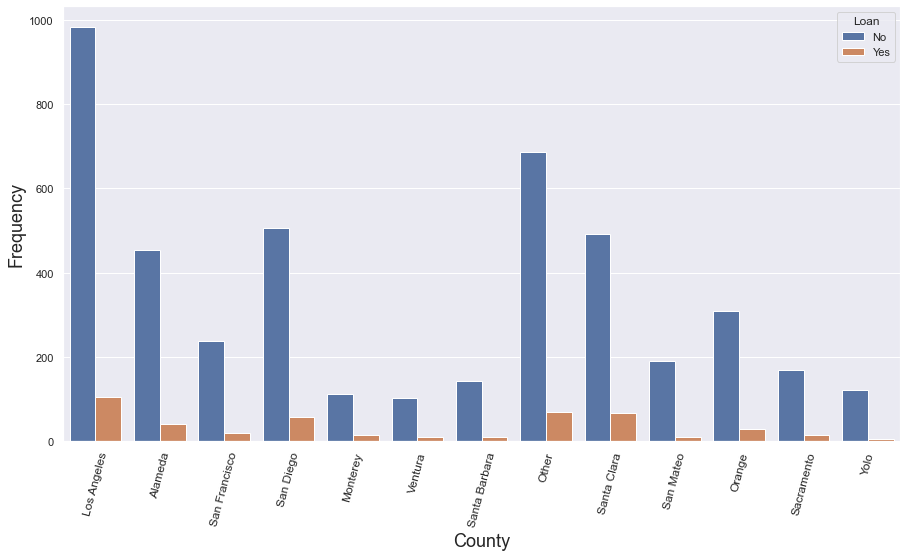

In [23]:
fig = plt.figure( figsize = (15,8) )
sns.countplot(x = 'County' , data = data, hue = 'Personal Loan')
plt.xlabel('County' , fontsize = 18);
plt.xticks(rotation = 75 , fontsize = 12);
plt.ylabel('Frequency' , fontsize = 18);
plt.legend(title='Loan', loc='upper right', labels=['No', 'Yes']);

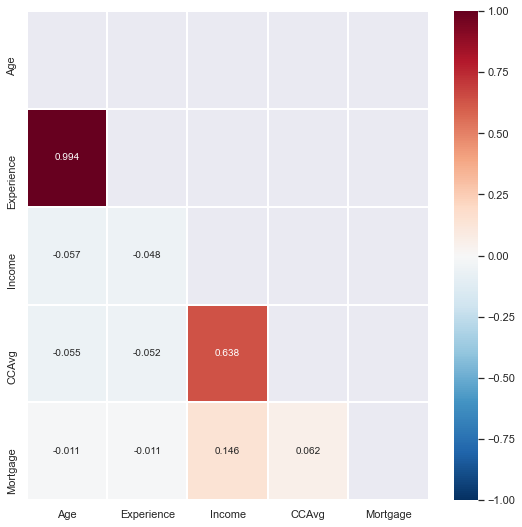

In [24]:
corr_matrix = data.loc[: , numeric_vars].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=np.bool))

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".3f",
            vmin=-1, vmax=1, linewidth = 1,
            center=0, mask=mask ,cmap="RdBu_r" , ax = ax);

Experience and Age are perfectly correlated so we can just drop one of the two to avoid multicollinearity.

In [25]:
data.drop(columns='Experience' , inplace=True)

In [26]:
# Keep a copy of the data without creating 'County' dummies - will be used for the hierarchical model later

data_hierarchical = pd.get_dummies(data, columns = ['Family', 'Education', 'Securities Account', 
                                       'CD Account', 'Online', 'CreditCard' ], drop_first = True)
encoder = OrdinalEncoder()

# Convert counties to numeric 
data_hierarchical['County'] = encoder.fit_transform(data_hierarchical['County'].values.reshape(-1, 1))
data_hierarchical['County'] = np.int64(data_hierarchical['County']) # change data type to integer

Finally, before we start fitting any models we need to create dummy variable columns for our categorical features.

In [27]:
data = pd.get_dummies(data, columns = ['Family', 'Education', 'Securities Account', 
                                       'CD Account', 'Online', 'CreditCard' , 'County'], drop_first = True)

In [28]:
data.head()

Age  Income  CCAvg  Mortgage  Personal Loan  Family_2  Family_3  Family_4  \
ID                                                                              
1    25      49    1.6         0              0         0         0         1   
2    45      34    1.5         0              0         0         1         0   
3    39      11    1.0         0              0         0         0         0   
4    35     100    2.7         0              0         0         0         0   
5    35      45    1.0         0              0         0         0         1   

    Education_2  Education_3  Securities Account_1  CD Account_1  Online_1  \
ID                                                                           
1             0            0                     1             0         0   
2             0            0                     1             0         0   
3             0            0                     0             0         0   
4             1            0                     0             0         0   
5             1            0                     0             0         0   

    CreditCard_1  County_Los Angeles  County_Monterey  County_Orange  \
ID                                                                     
1              0                   1                0              0   
2              0                   1                0              0   
3              0                   0                0              0   
4              0                   0                0              0   
5              1                   1                0              0   

    County_Other  County_Sacramento  County_San Diego  County_San Francisco  \
ID                                                                            
1              0                  0                 0                     0   
2              0                  0                 0                     0   
3              0                  0                 0                     0   
4              0                  0                 0                     1   
5              0                  0                 0                     0   

    County_San Mateo  County_Santa Barbara  County_Santa Clara  \
ID                                                               
1                  0                     0                   0   
2                  0                     0                   0   
3                  0                     0                   0   
4                  0                     0                   0   
5                  0                     0                   0   

    County_Ventura  County_Yolo  
ID                               
1                0            0  
2                0            0  
3                0            0  
4                0            0  
5                0            0

#### Let's now split the dataframe into the predictors and target dataframes

In [29]:
X , y = data.loc[ : , data.columns != 'Personal Loan'] , data.loc[ :, 'Personal Loan']

In [30]:
X_with_1s = sm.add_constant(X) # column of ones for intercept term
X_with_1s.rename(columns = {'const':'Intercept'} , inplace = True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_with_1s, y, test_size=0.15, random_state=8192) # NOTE: X_with_1s used

### Logistic regression using MLE

In [32]:
log_reg = sm.Logit(y_train , X_train).fit()

Optimization terminated successfully.
         Current function value: 0.112270
         Iterations 9


In [33]:
log_reg.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                  Logit              Pseudo R-squared:   0.635    
Dependent Variable:     Personal Loan      AIC:                998.2104 
Date:                   2021-05-01 08:49   BIC:                1163.2107
No. Observations:       4214               Log-Likelihood:     -473.11  
Df Model:               25                 LL-Null:            -1295.0  
Df Residuals:           4188               LLR p-value:        0.0000   
Converged:              1.0000             Scale:              1.0000   
No. Iterations:         9.0000                                          
------------------------------------------------------------------------
                      Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
------------------------------------------------------------------------
Intercept            -13.3320   0.8017 -16.6288 0.0000 -14.9034 -11.7606
Age                    0.0037   0.0077   0.4753 0.6346  -0.0115   0.0189
Income                 0.0641   0.0035  18.5085 0.0000   0.0574   0.0709
CCAvg                  0.1640   0.0511   3.2126 0.0013   0.0640   0.2641
Mortgage               0.0016   0.0007   2.2401 0.0251   0.0002   0.0030
Family_2              -0.1146   0.2573  -0.4454 0.6560  -0.6190   0.3897
Family_3               2.0076   0.2776   7.2308 0.0000   1.4634   2.5517
Family_4               1.6997   0.2669   6.3683 0.0000   1.1766   2.2229
Education_2            3.7831   0.3055  12.3849 0.0000   3.1844   4.3818
Education_3            4.0428   0.2975  13.5898 0.0000   3.4597   4.6259
Securities Account_1  -0.8718   0.3374  -2.5838 0.0098  -1.5330  -0.2105
CD Account_1           3.8129   0.3820   9.9805 0.0000   3.0641   4.5617
Online_1              -0.7650   0.1860  -4.1127 0.0000  -1.1296  -0.4004
CreditCard_1          -1.0936   0.2408  -4.5411 0.0000  -1.5657  -0.6216
County_Los Angeles     0.3322   0.3371   0.9853 0.3245  -0.3286   0.9929
County_Monterey        0.3713   0.6263   0.5928 0.5533  -0.8563   1.5988
County_Orange          0.3255   0.4390   0.7414 0.4584  -0.5350   1.1860
County_Other           0.5677   0.3596   1.5788 0.1144  -0.1370   1.2724
County_Sacramento      0.3343   0.5641   0.5926 0.5534  -0.7713   1.4398
County_San Diego       0.6216   0.3805   1.6339 0.1023  -0.1241   1.3673
County_San Francisco   0.3398   0.4884   0.6958 0.4866  -0.6174   1.2970
County_San Mateo      -1.1957   0.6490  -1.8423 0.0654  -2.4677   0.0764
County_Santa Barbara   0.5475   0.5952   0.9199 0.3576  -0.6191   1.7141
County_Santa Clara     0.7063   0.3753   1.8818 0.0599  -0.0293   1.4420
County_Ventura         0.8128   0.6030   1.3480 0.1777  -0.3690   1.9947
County_Yolo            0.1826   0.6434   0.2839 0.7765  -1.0784   1.4437
========================================================================

"""

Let's see how this model performs on unseen data.

Since our dataset is quite imbalanced in terms of the proportion of '1' and '0' in the target variable, balanced accuracy score is a more appropriate evaluation metric for the model compared to standard accuracy score.

In [34]:
mle_pred_probs = log_reg.predict(X_test) # returns predicted probabilities
mle_class_preds = mle_pred_probs.apply(lambda x: 1 if x > 0.5 else 0) # use threshold of 0.5 to classify an observation as 1
mle_fpr, mle_tpr, _ = roc_curve(y_test, mle_pred_probs) # False & True positive rates for the model

In [35]:
mle_bal_acc = balanced_accuracy_score(y_test, mle_class_preds) # MLE balanced accuracy
mle_auc = roc_auc_score(y_test, mle_pred_probs) # MLE AUC

### Bayesian Logistic regression using the Laplace approximation 

Prior used for Beta is a Unit information prior, i.e.  $\mathcal{N} \left(\mathbf{0}_p , \dfrac{1}{n} X^T X \right)$ where $X$ is the data matrix of the train set.

In [36]:
def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)

def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return - t

def neg_post(beta, x, y, m0, S0):
    logprior =  - .5 * (beta-m0).T @ S0 @ (beta-m0) # We use a Normal prior on beta
    return  nll(beta, x, y) -  logprior

def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y) + S0.dot(beta-m0)

def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta) * (1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec

def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        
        i += 1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
        
    if (iter == maxiter):
        print('Did not Converge') 
        
    return beta, H_inv

In [37]:
n , p = X_train.shape
beta0 = np.zeros(p)
m0 = np.zeros(p) # prior mean
S0 = X_train.T.dot(X_train) / n # prior variance
tolerance = 1e-05
maxiter = 100 
beta = beta0
beta_map , cov = NewtonRaphsonBayesLogReg(beta0, X_train, y_train, m0, S0, maxiter, tolerance) # returns mode and Hessian matrix

iteration  1  Negative Log Posterior  2920.922218879607  AbDiff  1
iteration  2  Negative Log Posterior  1018.3364677224223  AbDiff  1902.5857511571849
iteration  3  Negative Log Posterior  674.7992023855436  AbDiff  343.5372653368787
iteration  4  Negative Log Posterior  541.6534218226228  AbDiff  133.14578056292078
iteration  5  Negative Log Posterior  499.40984801951475  AbDiff  42.24357380310806
iteration  6  Negative Log Posterior  492.5236484840161  AbDiff  6.886199535498633
iteration  7  Negative Log Posterior  492.2657352478419  AbDiff  0.25791323617420403
iteration  8  Negative Log Posterior  492.2652738238139  AbDiff  0.00046142402800342097


In [38]:
N = 100_000 # number of Monte Carlo samples
betas = np.random.multivariate_normal(beta_map, cov, N)  # Sample from the Posterior using the Laplace approximation
Xbetas = X_test.dot(betas.T)
d = 1 / (1. + np.exp(-Xbetas))
pred_probs_laplace = np.mean(d, axis=1)
class_preds_laplace = (pred_probs_laplace > 0.5) 

We can see that the results obtained are almost identical for these two methods. Perhaps the Unit information prior we have used has little effect and the data essentially dominates in the posterior, hence yielding similar results to those obtaining via MLE.

MLE test set balanced accuracy: 0.8172 and AUC: 0.9640
Bayesian LogReg using Laplace test set balanced accuracy: 0.8095 and AUC: 0.9642


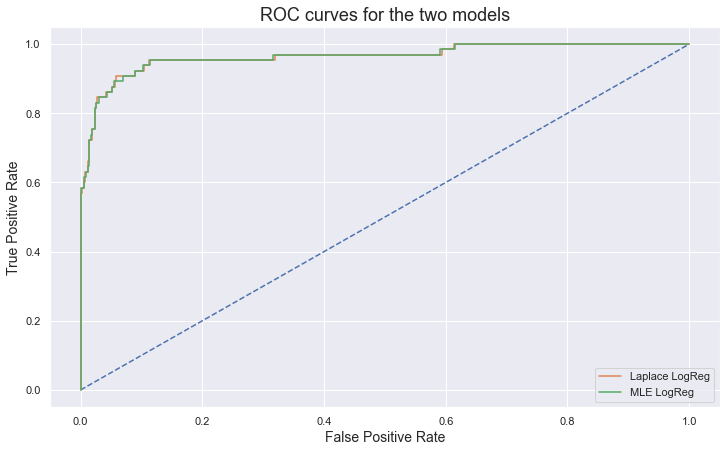

In [39]:
fig = plt.figure( figsize = (12, 7))
laplace_logreg_accuracy = balanced_accuracy_score(y_test, class_preds_laplace)
fpr_laplace, tpr_laplace, _ = roc_curve(y_test, pred_probs_laplace)
laplace_auc = roc_auc_score(y_test, pred_probs_laplace)

plt.plot([0, 1], [0, 1], linestyle='--');
plt.plot(fpr_laplace, tpr_laplace, label = 'Laplace LogReg')
plt.plot(mle_fpr, mle_tpr, label = 'MLE LogReg');
plt.legend();
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC curves for the two models', fontsize = 18)
plt.legend(loc="lower right",);
print(f'MLE test set balanced accuracy: {mle_bal_acc:.4f} and AUC: {mle_auc:.4f}')
print(f'Bayesian LogReg using Laplace test set balanced accuracy: {laplace_logreg_accuracy:.4f} and AUC: {laplace_auc:.4f}')

### Comparing coefficients obtained by sampling from the posterior using Laplace approximation vs MLE coefficients

In [40]:
n_beta_coeffs = len(betas[0])
coeffs_laplace = [] # coefficients obtained by taking the sample mean of samples from the posterior via Laplace

# Calculating posterior mean for each parameter
for j in range(n_beta_coeffs):
    beta_j = []
    for i in range(N):
        beta_j.append(betas[i][j])
    coeffs_laplace.append(np.mean(beta_j))

In [41]:
compare_params = pd.DataFrame({'Bayesian LogReg via Laplace approximation' : coeffs_laplace, 
                               'LogReg using MLE' : log_reg.params.values} , index = log_reg.params.index)

In [42]:
compare_params

Bayesian LogReg via Laplace approximation  \
Intercept                                            -12.456086   
Age                                                    0.003343   
Income                                                 0.059875   
CCAvg                                                  0.152281   
Mortgage                                               0.001512   
Family_2                                              -0.105569   
Family_3                                               1.874003   
Family_4                                               1.582313   
Education_2                                            3.492208   
Education_3                                            3.737911   
Securities Account_1                                  -0.821424   
CD Account_1                                           3.594742   
Online_1                                              -0.708747   
CreditCard_1                                          -1.016912   
County_Los Angeles                                     0.291935   
County_Monterey                                        0.324798   
County_Orange                                          0.283569   
County_Other                                           0.521929   
County_Sacramento                                      0.316366   
County_San Diego                                       0.572037   
County_San Francisco                                   0.302219   
County_San Mateo                                      -1.082729   
County_Santa Barbara                                   0.493010   
County_Santa Clara                                     0.636201   
County_Ventura                                         0.728213   
County_Yolo                                            0.154558   

                      LogReg using MLE  
Intercept                   -13.331978  
Age                           0.003682  
Income                        0.064144  
CCAvg                         0.164018  
Mortgage                      0.001621  
Family_2                     -0.114622  
Family_3                      2.007575  
Family_4                      1.699744  
Education_2                   3.783075  
Education_3                   4.042811  
Securities Account_1         -0.871757  
CD Account_1                  3.812926  
Online_1                     -0.765036  
CreditCard_1                 -1.093642  
County_Los Angeles            0.332158  
County_Monterey               0.371267  
County_Orange                 0.325517  
County_Other                  0.567679  
County_Sacramento             0.334258  
County_San Diego              0.621611  
County_San Francisco          0.339789  
County_San Mateo             -1.195661  
County_Santa Barbara          0.547516  
County_Santa Clara            0.706320  
County_Ventura                0.812830  
County_Yolo                   0.182650

### Bayesian Logistic regression using PyStan

For this model, we assign a $Cauchy \space (0,2)$ prior on the intercept term. The reason behind doing this is that we want to use the heavy tails property of the Cauchy distribution to reflect the uncertainty that we have about the value of the intercept. Moving on to the p-dimensional slope coefficients vector $\mathbf{\beta}$, we
choose a multivariate prior that should reflect the fact that almost all of the predictors are essentially
uncorrelated with each other, as we observed in the correlation matrix previously. To achieve this, we need to
have a diagonal covariance matrix. Hence, we choose to go for a weakly informative multivariate Normal
prior, $\mathcal{N}(0_p , \space 100 I_p)$, where $0_p$ is a p-dimensional zero vector and $I_p$ is the pxp identity matrix.

In [47]:
code = """                                                                                           
data {                                                                                               
  int<lower=1> N; // the number of training observations                                                       
  int<lower=0> N2; // the number of test observations                                                          
  int K; // the number of features (excluding the intercept term)                                                                   
  int y[N]; // the training set target vector                                                                           
  matrix[N,K] X; // the training set data matrix                                                                  
  matrix[N2,K] new_X; // the test set data matrix                                         
}                                                                                                    
parameters {                                                                                         
  real alpha; // intercept term                                                                                       
  vector[K] beta; // the slope parameters                                                        
}                                                                                                                                                                                           
model {                                                                                              
  alpha ~ cauchy(0,2); // prior for the intercept following Gelman 2008   
  
  beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(10, K))); // MVN(0,10 * Ik) prior on slope coefficients                                                                                                                                                   
                                                                                                     
  y ~ bernoulli_logit(alpha + X*beta);                                                                      
}                                                                                                    
generated quantities {

  vector[N] log_lik;
  vector[N2] y_pred;
  
  for (n in 1:N) {
  log_lik[n] = bernoulli_logit_lpmf(y[n] | alpha + X[n] * beta);
  }
                                                                               
  y_pred = alpha + new_X * beta; // the linear part predicted by the model; need to apply the sigmoid function to obtain probs.                                 
}                                                                                                    
"""               
                                                                                
                                                                                                     
stan_data = {                                                                                             
    'N': len(X_train),                                                                                        
    'N2': len(X_test),                                                                                     
    'K': X.shape[1],                                                                                        
    'y': y_train,                                                                                     
    'X': X_train.loc[ : , X_train.columns != 'Intercept'],                                                                                      
    'new_X': X_test.loc[ : , X_test.columns != 'Intercept'] }

In [48]:
SM = pystan.StanModel(model_code = code)                                                              
fit = SM.sampling(data = stan_data, iter = 6000, chains = 4 , n_jobs = -1, seed = 76876)
pickle.dump(fit, open('Bayes_LogReg.pkl', 'wb')) # Pickle the model to avoid the time-consuming process of fitting every time

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b552e7625bc5fdfe326f55f230114929 NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [45]:
fit = pickle.load(open('Bayes_LogReg.pkl','rb'))

In [49]:
# All diagnostic checks seem to be fine
pystan.check_hmc_diagnostics(fit)

{'n_eff': True,
 'Rhat': True,
 'divergence': True,
 'treedepth': True,
 'energy': True}

### Let's see the summary of our model below

In [50]:
sample_extract = fit.extract(permuted=True) # extract samples from the model
print(fit.stansummary(pars = ['alpha','beta'], probs = (0.025, 0.975)))

Inference for Stan model: anon_model_b552e7625bc5fdfe326f55f230114929.
4 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

           mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha    -13.44    0.01    0.8 -15.05  -11.9   3463    1.0
beta[1]  3.5e-3  8.0e-5 7.8e-3  -0.01   0.02   9440    1.0
beta[2]    0.06  4.8e-5 3.5e-3   0.06   0.07   5380    1.0
beta[3]    0.17  5.1e-4   0.05   0.06   0.27  10054    1.0
beta[4]  1.6e-3  5.3e-6 7.3e-4 2.1e-4 3.1e-3  18599    1.0
beta[5]   -0.14  2.8e-3   0.26  -0.65   0.36   8344    1.0
beta[6]    2.03  3.4e-3   0.28   1.49   2.59   6678    1.0
beta[7]    1.71  3.3e-3   0.27   1.19   2.25   6764    1.0
beta[8]     3.8  4.0e-3   0.31   3.22   4.42   5803    1.0
beta[9]    4.07  4.1e-3    0.3    3.5   4.67   5252    1.0
beta[10]  -0.88  3.4e-3   0.33  -1.55  -0.24   9604    1.0
beta[11]   3.83  4.5e-3   0.38    3.1   4.59   7150    1.0
beta[12]  -0.77  1.8e-3   0.19  -1.14  -0.4

In [51]:
# Needed for calculating LOO
blr_inf_data = az.from_pystan(fit, log_likelihood = 'log_lik')

INFO:numba.core.transforms:finding looplift candidates


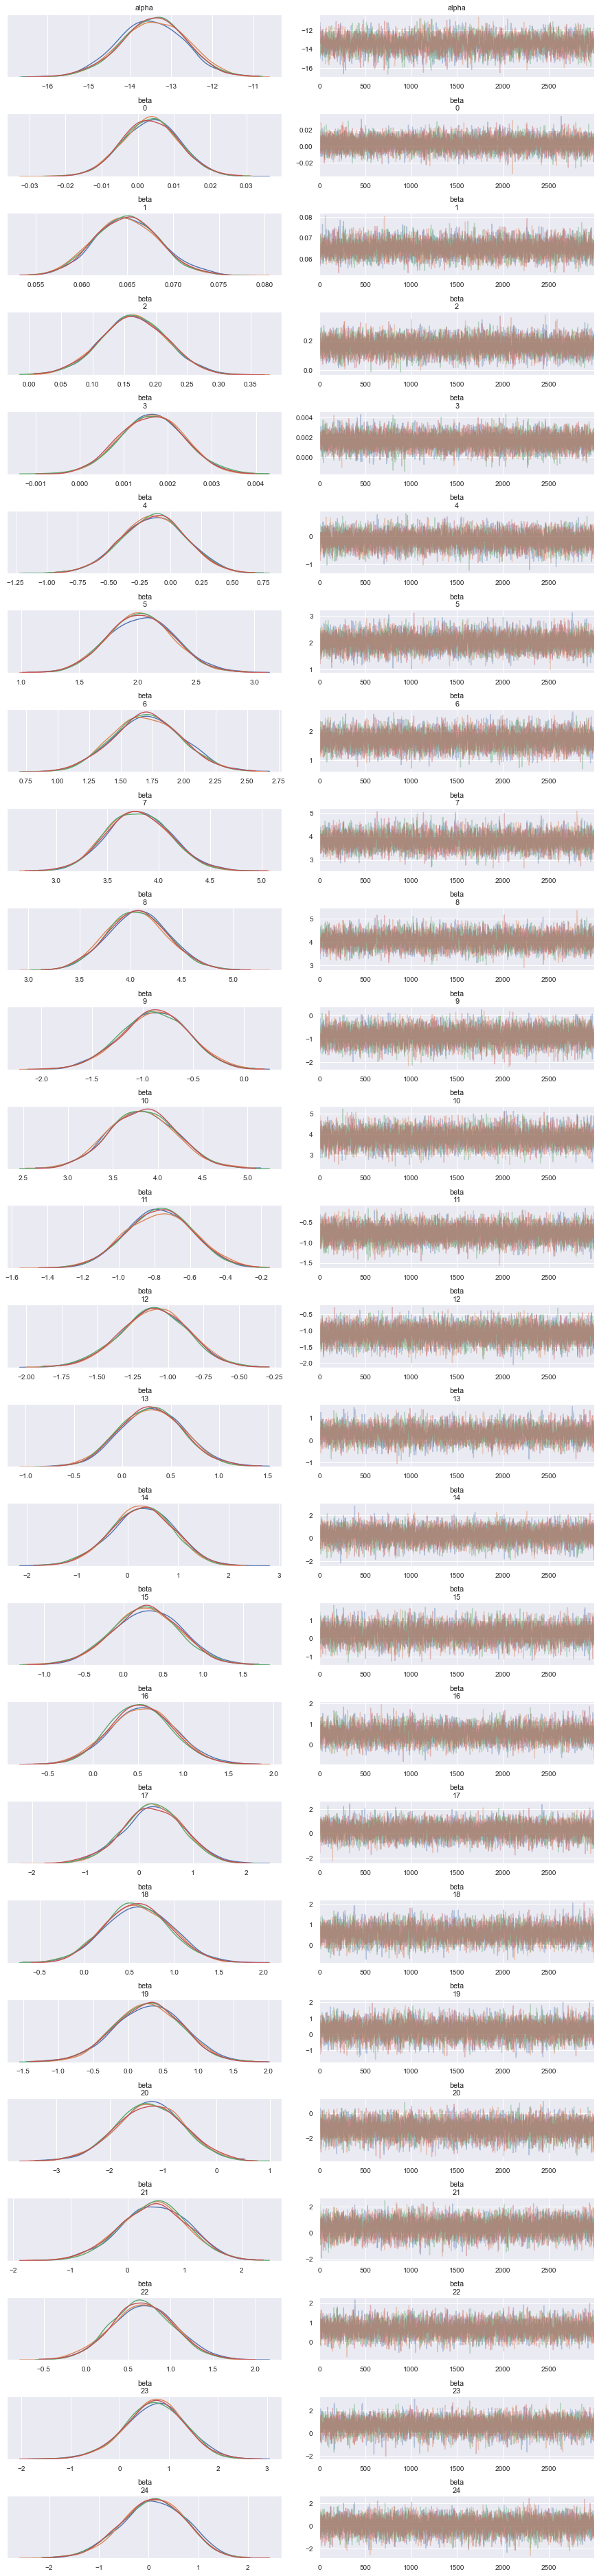

In [49]:
# MCMC results seem excellent here
ax = az.plot_trace(fit, var_names = ["alpha", "beta"])

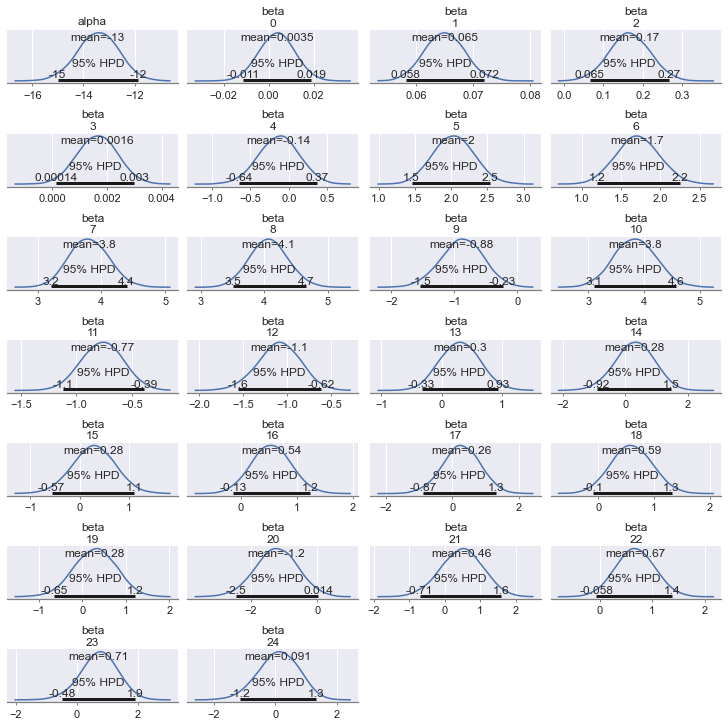

In [50]:
# Posterior distribution plots and Credible intervals
posterior_data = az.convert_to_dataset(fit) 
az.plot_posterior(data = posterior_data , var_names = ['alpha','beta'], figsize=(10,10), point_estimate='mean',
                  credible_interval=0.95);

INFO:numba.core.transforms:finding looplift candidates


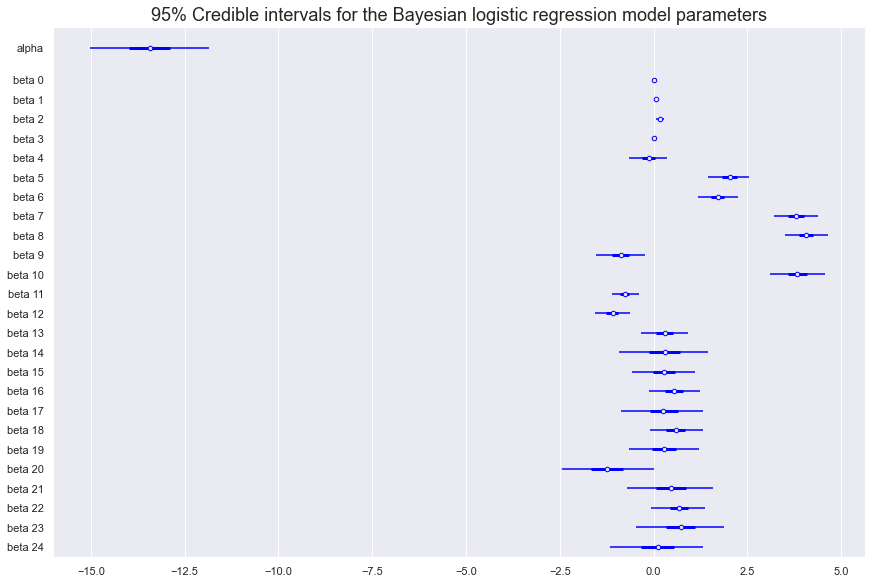

In [51]:
# Plot displaying only the 95% credible intervals
axes = az.plot_forest(
    posterior_data,
    kind = "forestplot",
    credible_interval = 0.95,
    var_names= ['alpha', 'beta'],
    combined = True,
    ridgeplot_overlap = 1.5,
    colors = "blue",
    figsize = (12, 8),
)
axes[0].set_title('95% Credible intervals for the Bayesian logistic regression model parameters' , fontsize=18);

### Predictions with our Bayesian Logistic regression model using the Predictive distribution

In [52]:
SM_pred_probs = expit(sample_extract['y_pred'].mean(0)) # predicted probabilities on the test set
SM_class_preds = np.where(SM_pred_probs > 0.5, 1, 0) # use threshold of 0.5 to classify an observation as 1
fpr_bayes , tpr_bayes , _ = roc_curve(y_test, SM_pred_probs) # false positive and true positive rates for ROC
bayes_auc = roc_auc_score(y_test, SM_pred_probs)
bayes_balanced_acc = balanced_accuracy_score(y_test, SM_class_preds)

### Moving on to the Hierarchical Logistic regression model

In [43]:
# Note the use of 'data_hierarchical' dataframe in this part
X_train_hier, X_test_hier, y_train_hier, y_test_hier = train_test_split(data_hierarchical.loc[ : , data_hierarchical.columns != 'Personal Loan'], 
                                                                                    y, test_size=0.15, random_state=8192)

In [44]:
county_train = X_train_hier.loc[: , 'County']
county_test = X_test_hier.loc[: , 'County']
X_train_hier.drop(columns = 'County' , inplace=True)
X_test_hier.drop(columns = 'County' , inplace=True)

In [45]:
X_train_hier.head()

Age  Income  CCAvg  Mortgage  Family_2  Family_3  Family_4  Education_2  \
ID                                                                              
3474   59      52    0.7         0         0         0         1            0   
1793   46     118    5.7         0         0         0         0            0   
105    56      38    1.3       166         0         0         1            0   
1076   41      59    0.2         0         0         0         1            0   
4187   33      10    1.0        81         0         0         1            0   

      Education_3  Securities Account_1  CD Account_1  Online_1  CreditCard_1  
ID                                                                             
3474            0                     1             0         0             0  
1793            0                     0             1         1             1  
105             0                     0             0         1             1  
1076            1                     0             0         0             0  
4187            0                     0             0         0             1

## Hierarchical model with random intercept AND random slope for the CCAvg variable, since the Bayesian logistic regression model suggests that it is an important predictor.

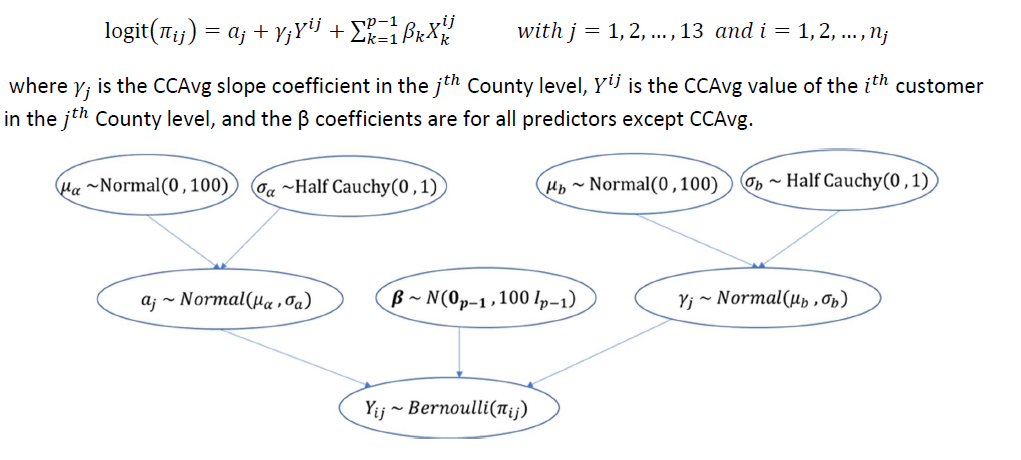

In [53]:
# Stan code for the Hierarchical Logistic regression model with random intercept and slope for CCAvg
hr_2 = """
data {
  int<lower=1> N; // the number of training observations                                                       
  int<lower=0> N2; // the number of test observations                                                          
  int K; // the number of features (excluding the intercept term) 
  int<lower=0> L; // Number of levels (Counties in our case)
  int<lower=0,upper=1> y[N]; // the training set target vector
  int<lower=0,upper=L> county[N];  // county vector in the training set 
  int<lower=0,upper=L> new_county[N2];  // county vector in the test set 
  matrix[N,K-1] X; // the training set data matrix excluding CCAvg feature
  vector[N] CCAvg; // training set CCAvg feature vector
  matrix[N2,K-1] new_X; // the test set data matrix excluding CCAvg feature
  vector[N2] new_CCAvg; // test set CCAvg feature vector
}

parameters {
  vector[L] alpha; // intercept vector (different intercept for each county level)
  vector[K-1] beta; // the slope parameters for all features except CCAvg
  vector[L] gamma; // CCAvg slope vector (different slope parameter for each county level)
  
  real<lower=0> sigma_a; // for the intercept 
  real mu_a; // for the intercept
  real<lower=0> sigma_b; // for the CCAvg slope
  real mu_b; // for the CCAvg slope
}

model {

  for (n in 1:N)
      y[n] ~ bernoulli_logit( alpha[county[n] + 1] + CCAvg[n] * gamma[county[n] + 1] + X[n] * beta );
      
  alpha ~ normal(mu_a, sigma_a); // prior on intercept vector
  
  gamma ~ normal(mu_b, sigma_b); // prior on CCAvg slope vector
  
  beta ~ multi_normal(rep_vector(0, K-1), diag_matrix(rep_vector(10, K-1))); // MVN(0 , 10 * I(k-1)) prior on slope coefficients
  
  
  mu_a ~ normal(0, 10); // Hyper-prior on mu_a
  sigma_a ~ cauchy(0,1); // Hyper-prior on sigma_a
  
  mu_b ~ normal(0, 10); // ''''
  sigma_b ~ cauchy(0,1); // ''''
}

generated quantities {                                                                               
  vector[N2] y_pred;
  vector[N] log_lik;
  
  for (n in 1:N2)
      y_pred[n] = alpha[new_county[n] + 1] + new_X[n] * beta + new_CCAvg[n] * gamma[county[n] + 1]; // Need to apply sigmoid to these values
      
  for (n in 1:N) {
  log_lik[n] = bernoulli_logit_lpmf(y[n] | alpha[county[n] + 1] + X[n] * beta + CCAvg[n] * gamma[county[n] + 1] );
  }
}     
"""

hierarchical_2 = {                                                                                             
    'N': len(X_train_hier),
    'N2': len(X_test_hier),
    'K': X_train_hier.shape[1] ,                                                                                        
    'y': y_train_hier,                                                                                     
    'X': X_train_hier.loc[ : , X_train_hier.columns != 'CCAvg'],
    'new_X': X_test_hier.loc[ : , X_test_hier.columns != 'CCAvg'],
    'CCAvg': X_train_hier.loc[:, 'CCAvg'],
    'new_CCAvg': X_test_hier.loc[:, 'CCAvg'],
    'L': len(county_train.unique()),
    'county': county_train,
    'new_county': county_test
}

In [54]:
rand_slope = pystan.StanModel(model_code = hr_2)                                                               
fit3 = rand_slope.sampling(data = hierarchical_2, iter = 6000, chains = 4 , seed = 65162, 
                      n_jobs = -1, control = {'adapt_delta':0.90})

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_30bfd9a792b3e5df5ef48315afd1827a NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [55]:
# Diagnostics could have been better but not bad
pystan.check_hmc_diagnostics(fit3)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': False,
 'energy': False}

In [56]:
hier_inf_data2 = az.from_pystan(fit3, log_likelihood = 'log_lik')

In [57]:
# Rhat and n_eff are very good
hr_rand_slope = fit3.extract(permuted=True) # extract samples from the model
print(fit3.stansummary(pars = ['alpha','beta', 'gamma','mu_a','sigma_a','mu_b','sigma_b'], probs = (0.025, 0.975)))

Inference for Stan model: anon_model_30bfd9a792b3e5df5ef48315afd1827a.
4 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

            mean se_mean     sd    2.5%  97.5%  n_eff   Rhat
alpha[1]  -13.02    0.02   0.76  -14.56  -11.6   1224    1.0
alpha[2]  -12.93    0.02   0.74   -14.4 -11.53   1266    1.0
alpha[3]  -12.93    0.02   0.76  -14.45 -11.49   1310    1.0
alpha[4]  -12.95    0.02   0.75  -14.46 -11.52   1250    1.0
alpha[5]  -12.85    0.02   0.74  -14.34 -11.46   1287    1.0
alpha[6]  -12.93    0.02   0.75  -14.42 -11.52   1274    1.0
alpha[7]  -12.84    0.02   0.74   -14.3 -11.45   1303    1.0
alpha[8]  -12.93    0.02   0.75  -14.44 -11.52   1273    1.0
alpha[9]  -13.15    0.02   0.79  -14.77 -11.68   1188    1.0
alpha[10] -12.89    0.02   0.76  -14.42 -11.46   1326    1.0
alpha[11] -12.82    0.02   0.74  -14.29 -11.42   1295    1.0
alpha[12] -12.88    0.02   0.75  -14.39 -11.45   1290    1.0
alpha[13] -12.95 

## Hierarchical model with just random intercept

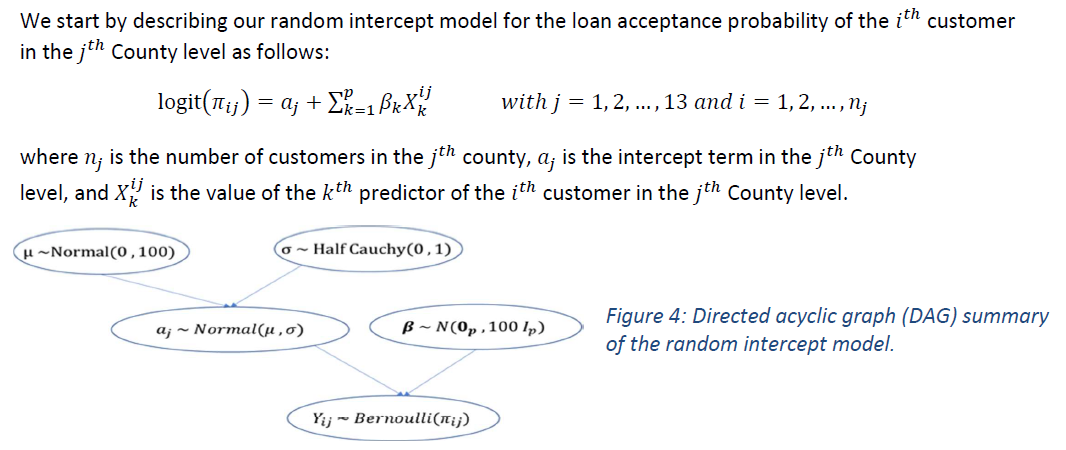

In [46]:
# Stan code for the Hierarchical Logistic regression model with random intercept only
hr = """
data {
  int<lower=1> N; // the number of training observations                                                       
  int<lower=0> N2; // the number of test observations                                                          
  int K; // the number of features (excluding the intercept term) 
  int<lower=0> L; // Number of levels (Counties in our case)
  int<lower=0,upper=1> y[N]; // the training set target vector
  int<lower=0,upper=L> county[N];  // county vector in the training set 
  int<lower=0,upper=L> new_county[N2];  // county vector in the test set 
  matrix[N,K] X; // the training set data matrix                                                                  
  matrix[N2,K] new_X; // the test set data matrix
}

parameters {
  vector[L] alpha; // intercept vector (different intercept for each county level)
  vector[K] beta; // the slope parameters (same slopes vector for each county level)
  real<lower=0> sigma; 
  real mu; // mean 
}

model {

  for (n in 1:N)
      y[n] ~ bernoulli_logit( alpha[county[n] + 1] + X[n] * beta );
      
  alpha ~ normal(mu,sigma); // prior on intercept vector
  
  beta ~ multi_normal(rep_vector(0, K), diag_matrix(rep_vector(10, K))); // MVN(0 , 10 * Ik) prior on slope coefficients
  
  mu ~ normal(0,10); // Hyper-prior on mu
  sigma ~ cauchy(0,1); // Hyper-prior on sigma
}

generated quantities {                                                                               
  vector[N2] y_pred;
  vector[N] log_lik;
  
  for (n in 1:N2)
      y_pred[n] = alpha[new_county[n] + 1] + new_X[n] * beta; // Need to apply sigmoid to these values to get the probability
      
  for (n in 1:N) {
  log_lik[n] = bernoulli_logit_lpmf(y[n] | alpha[county[n] + 1] + X[n] * beta );
  }
}     
"""

hierarchical_data = {                                                                                             
    'N': len(X_train_hier),
    'N2': len(X_test_hier),
    'K': X_train_hier.shape[1] ,                                                                                        
    'y': y_train_hier,                                                                                     
    'X': X_train_hier,
    'new_X': X_test_hier,
    'L': len(county_train.unique()),
    'county': county_train,
    'new_county': county_test
}

In [48]:
hier_M = pystan.StanModel(model_code = hr)                                                               
fit2 = hier_M.sampling(data = hierarchical_data, iter = 6000, chains = 4 , seed = 65162, n_jobs = -1, control = {'adapt_delta':0.90})
pickle.dump(fit2, open('Hierarchical_Model.pkl', 'wb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d185441b1039181b20cae0ec5724d2ab NOW.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [49]:
fit2 = pickle.load(open('Hierarchical_Model.pkl','rb'))

In [50]:
# Diagnostics seem relatively fine overall
pystan.check_hmc_diagnostics(fit2)

{'n_eff': True,
 'Rhat': True,
 'divergence': False,
 'treedepth': True,
 'energy': True}

In [61]:
hier_inf_data = az.from_pystan(fit2, log_likelihood = 'log_lik')

In [62]:
# Bayesian model selection by comparing the 3 Bayesian models according to the LOO CV criterion
az.compare({'Random intercept model':hier_inf_data, 'Random intercept & slope model' : hier_inf_data2,
            'Bayesian LogReg':blr_inf_data} , ic = 'LOO')

rank      loo    p_loo    d_loo     weight  \
Random intercept model            0  990.716  17.5883        0   0.656023   
Random intercept & slope model    1  992.519  19.8812  1.80308   0.276366   
Bayesian LogReg                   2  998.318  25.5306   7.6023  0.0676108   

                                     se      dse warning loo_scale  
Random intercept model          62.3171        0   False  deviance  
Random intercept & slope model  62.4795  1.10365   False  deviance  
Bayesian LogReg                  63.009  4.46412   False  deviance

* We see that the LOO value for the two Hierarchical models is quite close but we choose the more parsimonious random intercept model as our final Hierarchical model.

In [51]:
# A few parameters could have been better in terms of n_eff and Rhat but overall nothing too concerning 

hr_sample_extract = fit2.extract(permuted=True) # extract samples from the model
print(fit2.stansummary(pars = ['alpha','beta','mu','sigma'], probs = (0.025, 0.975)))

Inference for Stan model: anon_model_d185441b1039181b20cae0ec5724d2ab.
4 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=12000.

            mean se_mean     sd   2.5%  97.5%  n_eff   Rhat
alpha[1]  -13.01    0.02    0.7 -14.52 -11.69   1193   1.01
alpha[2]   -12.9    0.02   0.68 -14.34 -11.62   1224   1.01
alpha[3]  -12.89    0.02    0.7 -14.38 -11.55   1291   1.01
alpha[4]   -12.9    0.02    0.7 -14.38  -11.6   1243   1.01
alpha[5]   -12.8    0.02   0.68 -14.24 -11.51   1246   1.01
alpha[6]  -12.89    0.02    0.7 -14.37 -11.55   1261   1.01
alpha[7]  -12.79    0.02   0.68 -14.21  -11.5   1248   1.01
alpha[8]   -12.9    0.02   0.69 -14.36 -11.57   1267   1.01
alpha[9]  -13.13    0.02   0.74 -14.72 -11.77   1117   1.01
alpha[10] -12.86    0.02    0.7 -14.33 -11.52   1316   1.01
alpha[11] -12.76    0.02   0.68 -14.19 -11.46   1265   1.01
alpha[12] -12.83    0.02    0.7 -14.31 -11.48   1307   1.01
alpha[13] -12.91    0.02   0.7

**NOTE:** alpha[9] and alpha[11] correspond to the intercepts for the San Mateo (County value of '8') and Santa Clara (County value of '10') counties. Looking back at our 'County' barplot, these coefficient numbers make perfect sense! 

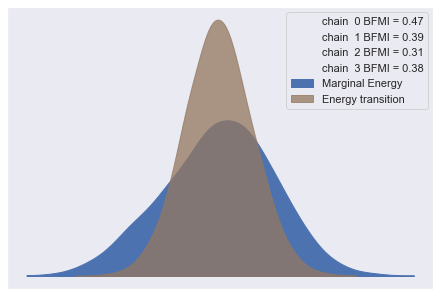

In [52]:
# All of the BFMI values are >0.3 so overall fine
hier_data = az.convert_to_inference_data(fit2)
az.plot_energy(hier_data);

INFO:numba.core.transforms:finding looplift candidates


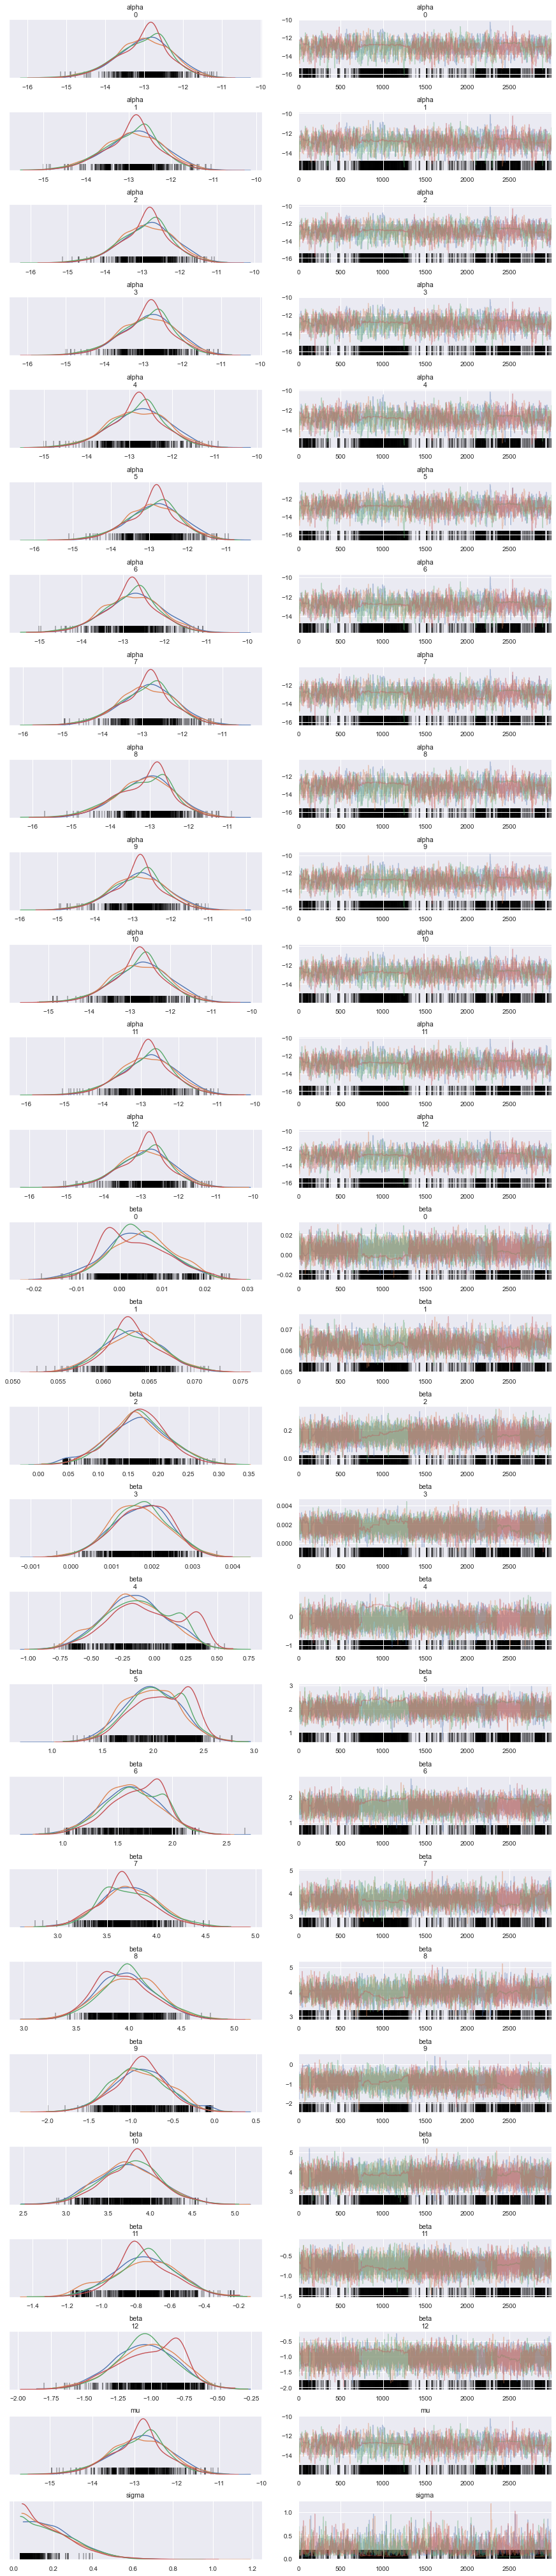

In [53]:
# MCMC results are as expected not as good as with the Bayesian LogReg model, although decent enough for our analysis
ax2 = az.plot_trace(fit2, var_names = ['alpha','beta','mu','sigma'])

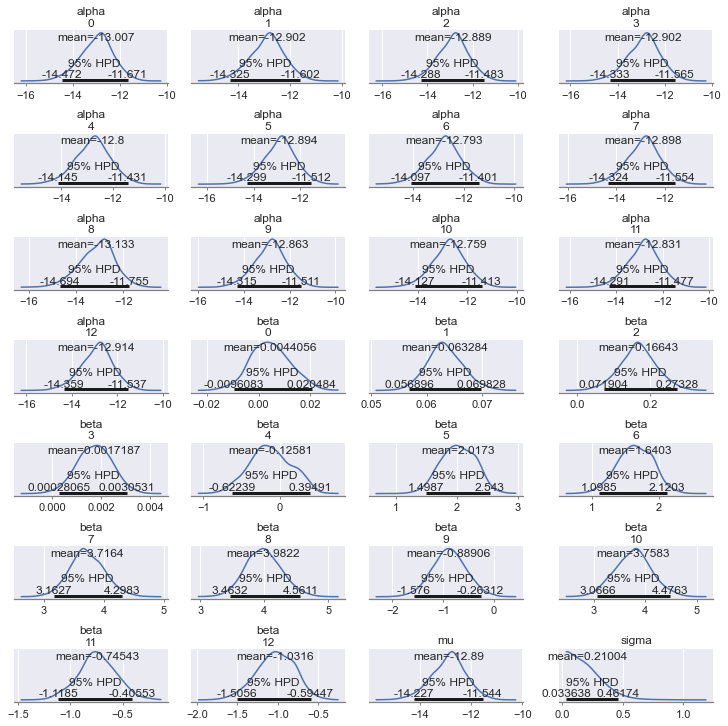

In [58]:
hier_posterior_data = az.convert_to_dataset(fit2)

az.plot_posterior(data = hier_posterior_data , var_names = ['alpha','beta','mu','sigma'], 
                  figsize=(10,10), point_estimate='mean', credible_interval=0.95, round_to = 5);

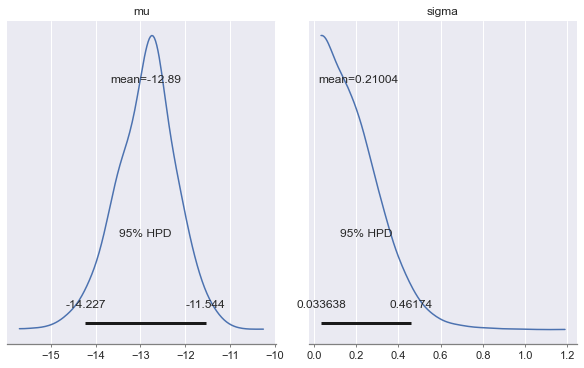

In [60]:
az.plot_posterior(data = hier_posterior_data , var_names = ['mu','sigma'], 
                  figsize=(8,5), point_estimate='mean', credible_interval=0.95, round_to = 5);

INFO:numba.core.transforms:finding looplift candidates


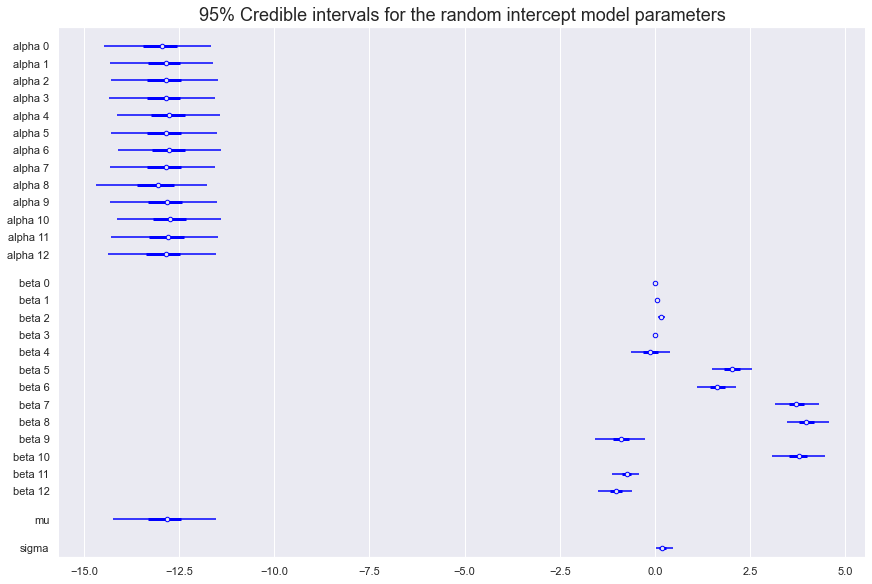

In [55]:
# Plot displaying only the 95% credible intervals

axes = az.plot_forest(
    hier_posterior_data,
    kind = "forestplot",
    credible_interval = 0.95,
    var_names= ['alpha', 'beta','mu','sigma'],
    combined = True,
    ridgeplot_overlap = 1.5,
    colors = "blue",
    figsize = (12, 8),
)
axes[0].set_title('95% Credible intervals for the random intercept model parameters' , fontsize=18);

### Assessing the predictions of our random intercept Hierarchical Model

In [68]:
hier_pred_probs = expit(hr_sample_extract['y_pred'].mean(0)) # predicted probabilities on the test set
hier_class_preds = np.where(hier_pred_probs > 0.5, 1, 0) # use threshold of 0.5 to classify an observation as 1

In [69]:
fpr_hier , tpr_hier , _ = roc_curve(y_test_hier, hier_pred_probs)
hier_auc = roc_auc_score(y_test_hier, hier_pred_probs)
hier_balanced_acc = balanced_accuracy_score(y_test_hier, hier_class_preds)

Comparing the Bayesian Logistic regression model, random intercept Hierarchical model and MLE model in terms of balanced accuracy and AUC scores on the test set. We don't see any clear results in terms of which model is better for out-of-sample prediction.

MLE test set balanced accuracy: 0.8172 and AUC: 0.9640
Bayesian Logistic regression test set balanced accuracy: 0.8095 and AUC: 0.9643
Random intercept Hierarchical Logistic regression test set balanced accuracy: 0.8102 and AUC: 0.9649


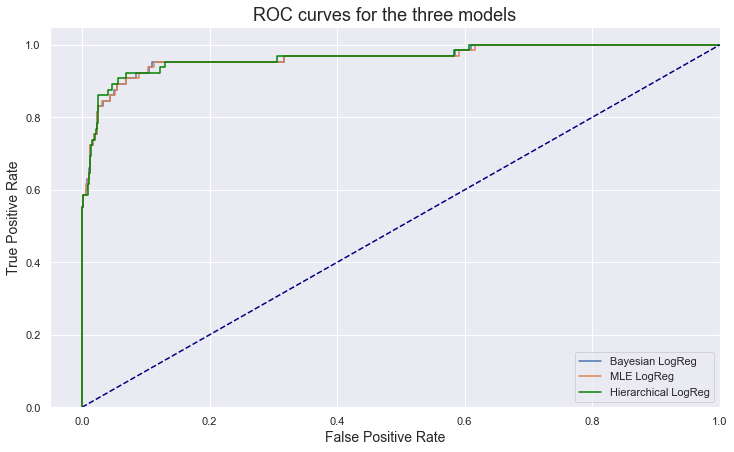

In [70]:
plt.figure(figsize=(12,7))
plt.plot(fpr_bayes, tpr_bayes, label = 'Bayesian LogReg')
plt.plot(mle_fpr, mle_tpr, label = 'MLE LogReg');
plt.plot(fpr_hier, tpr_hier, color='green', label='Hierarchical LogReg', clip_on=False)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 14)
plt.ylabel('True Positive Rate', fontsize = 14)
plt.title('ROC curves for the three models', fontsize = 18)
plt.legend(loc="lower right",);
print(f'MLE test set balanced accuracy: {mle_bal_acc:.4f} and AUC: {mle_auc:.4f}')
print(f'Bayesian Logistic regression test set balanced accuracy: {bayes_balanced_acc:.4f} and AUC: {bayes_auc:.4f}')
print(f'Random intercept Hierarchical Logistic regression test set balanced accuracy: {hier_balanced_acc:.4f} and AUC: {hier_auc:.4f}')